## Введение

Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.

На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.

Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:

$$ L(y, z) = -y * log(z) - (1 - y) * log(1 - z) $$ 

Здесь через y обозначен истинный ответ, через z — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

## Реализация в sklearn

В пакете scikit-learn градиентный бустинг реализован в модуле ensemble в виде классов GradientBoostingClassifier и GradientBoostingRegressor. Основные параметры, которые будут интересовать нас: n_estimators, learning_rate. Иногда может быть полезен параметр verbose для отслеживания процесса обучения.

Чтобы была возможность оценить качество построенной композиции на каждой итерации, у класса есть метод staged_decision_function. Для заданной выборки он возвращает ответ на каждой итерации.

Помимо алгоритмов машинного обучения, в пакете scikit-learn представлено большое число различных инструментов. В этом задании будет предложено воспользоваться функцией train_test_split модуля cross_validation. С помощью нее можно разбивать выборки случайным образом. На вход можно передать несколько выборок (с условием, что они имеют одинаковое количество строк). Пусть, например, имеются данные X и y, где X — это признаковое описание объектов, y — целевое значение. Тогда следующий код будет удобен для разбиения этих данных на обучающее и тестовое множества:

```
X_train, X_test, y_train, y_test = 
      train_test_split(X, y, test_size=0.33, random_state=42)
```

Обратите внимание, что при фиксированом параметре random_state результат разбиения можно воспроизвести.

Метрика log-loss реализована в пакете metrics: sklearn.metrics.log_loss. Заметим, что данная метрика предназначена для классификаторов, выдающих оценку принадлежности классу, а не бинарные ответы. И градиентный бустинг, и случайный лес умеют строить такие прогнозы — для этого нужно использовать метод predict_proba:

```
pred = clf.predict_proba(X_test)[:, 1]
```

Метод predict_proba возвращает матрицу, i-й столбец которой содержит оценки принадлежности i-му классу. В примере мы берем столбец с оценками принадлежности первому классу.

Для рисования кривых качества на обучении и контроле можно воспользоваться следующим кодом:

```
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(test_loss, 'r', linewidth=2)
plt.plot(train_loss, 'g', linewidth=2)
plt.legend(['test', 'train'])
```

## Материалы

[Подробнее о градиентном бустинге и особенностях его применения к деревьям](http://www.machinelearning.ru/wiki/images/7/7e/Sem03_ensembles_2014.pdf)

## Данные
%matplotlib inline
В рамках данного задания мы рассмотрим датасет с конкурса [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse).

## Инструкция по выполнению

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

* Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.

In [2]:
data = pd.read_csv('data/gbm-data.csv')

In [3]:
y = data.loc[:, 'Activity']
X = data.drop('Activity', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.8, random_state = 241)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((750, 1776), (750,), (3001, 1776), (3001,))


* Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:
  * Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.
  * Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказаное значение.
  * Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

In [4]:
def sig(y_pred):
    return 1. / (1. + math.e ** -y_pred)

Rate: 1.0
Min @test: [(1, 0.58229425942784752)]


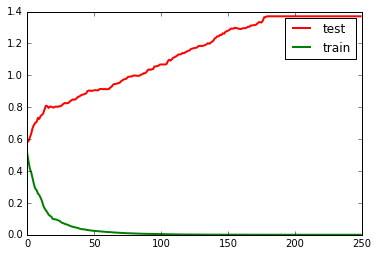

Rate: 0.5
Min @test: [(7, 0.55820255231642613)]


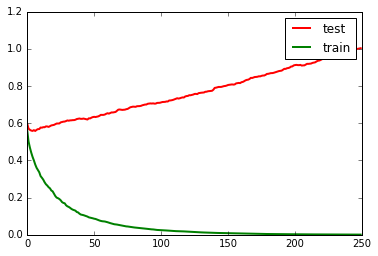

Rate: 0.3
Min @test: [(19, 0.54274517734331229)]


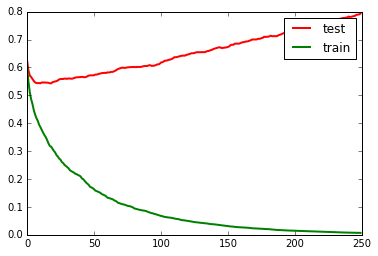

Rate: 0.2
Min @test: [(37, 0.53091815680290511)]


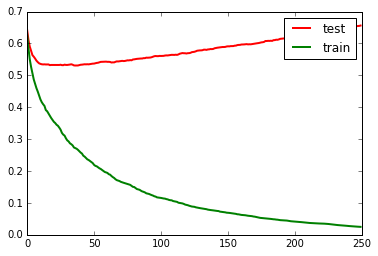

Rate: 0.1
Min @test: [(52, 0.52646461382579068)]


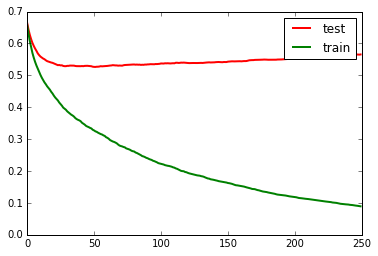

In [6]:
for rate in [1., 0.5, 0.3, 0.2, 0.1]:
    print('Rate: ' + str(rate))
    clf = GradientBoostingClassifier(learning_rate = rate, n_estimators=250, verbose=False, random_state=241)
    clf.fit(X_train, y_train)
    test_loss = [log_loss(y_test, sig(y_pred)) for y_pred in clf.staged_decision_function(X_test)]
    train_loss = [log_loss(y_train, sig(y_pred)) for y_pred in clf.staged_decision_function(X_train)]
    print('Min @test:'),
    min_loss = min(test_loss)
    print([tuple_ for tuple_ in zip(range(1, len(test_loss)), test_loss) if tuple_[1] == min_loss])
    plt.figure()
    plt.plot(test_loss, 'r', linewidth=2)
    plt.plot(train_loss, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    plt.show()

* Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting. 
 - overfitting

* Приведите минимальное значение log-loss и номер итерации, на котором оно достигается, при learning_rate = 0.2. 
 - [0.53, 37], Уже после 37-й итерации можно наблюдать переобучение.
 
Comment A: Подскажите - зачем мы считаем сигмоид: 1 / (1 + e^(-y_pred)) перед тем как сравнивать с настоящим y? Ведь staged_decision_function по-идее должен возвращать уже предсказываемые значения. И самым странным для меня оказалось что для случайного леса считать сигмоид не надо (по крайней мере, чтобы грейдер принял ответ).

Comment B: Насколько я понимаю, staged_decision_function возвращает функцию отступа. Чтоб отступ превратить в вероятность попадания в класс [y==1], с которой работает log_loss, к нему и применяется сигмоид. Сигмоид от decision_function это и есть predict_proba, если для классификатора указано loss='deviance'.

* На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba)

In [13]:
clf = GradientBoostingClassifier(n_estimators=37, verbose=False, random_state=241)
clf.fit(X_train, y_train)
test_loss = [log_loss(y_test, sig(y_pred)) for y_pred in clf.staged_decision_function(X_test)]
print(test_loss[-1])

0.529496606165


In [33]:
print(log_loss(y_test, clf.predict_proba(X_test)))

0.529496606165


Обратите внимание, что, хотя в градиентного бустинге гораздо более слабые базовые алгоритмы, он выигрывает у случайного леса благодаря более "направленной" настройке — каждый следующий алгоритм исправляет ошибки имеющейся композиции. Также он обучается быстрее случайного леса благодаря использованию неглубоких деревьев. В то же время, случайный лес может показать более высокое качество при неограниченных ресурсах — так, он выиграет у градиентного бустинга на наших данных, если увеличить число деревьев до нескольких сотен (проверьте сами!).